In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vibhingupta028/liver-histopathology-fibrosis-ultrasound-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/liver-histopathology-fibrosis-ultrasound-images


In [4]:
ls /kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset

F0/  F1/  F2/  F3/  F4/


In [5]:
import os

DATA_DIR = "/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset"
assert os.path.exists(DATA_DIR), "Dataset path not found!"

In [6]:
from torch.utils.data import Dataset
import os
import cv2
from torchvision import transforms

class LiverFibrosisDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for idx, cls in enumerate(self.classes):
            class_path = os.path.join(root_dir, cls)
            for img_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=image)['image']

        return image, label

In [7]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# transform = A.Compose([
#     A.Resize(224, 224),
#     A.Normalize(mean=(0.5,), std=(0.5,)),
#     ToTensorV2()
# ])

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [33]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2 # Import cv2 for some augmentation parameters

transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    A.VerticalFlip(p=0.2),    # Randomly flip the image vertically
    A.RandomRotate90(p=0.5),  # Randomly rotate the image by 90 degrees
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5), # Randomly apply affine transformations
    A.OneOf([                 # Apply one of the following transformations
        A.GaussNoise(p=0.2),
        A.ISONoise(p=0.2),
    ], p=0.2),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

In [34]:
from torch.utils.data import DataLoader

dataset = LiverFibrosisDataset(DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.shared_mlp = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = self.shared_mlp(self.avg_pool(x))
        max_ = self.shared_mlp(self.max_pool(x))
        return self.sigmoid(avg + max_)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel = ChannelAttention(in_planes, ratio)
        self.spatial = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel(x)
        x = x * self.spatial(x)
        return x

In [36]:
import timm

class EfficientNetCBAM(nn.Module):
    def __init__(self, num_classes=5):
        super(EfficientNetCBAM, self).__init__()
        self.backbone = timm.create_model("efficientnet_b4", pretrained=True)
        self.cbam = CBAM(in_planes=1792)  # B4 final output has 1792 channels
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1792, num_classes)

    def forward(self, x):
        features = self.backbone.forward_features(x)  # ✅ full final features
        features = self.cbam(features)
        pooled = self.pool(features).view(x.size(0), -1)
        out = self.fc(pooled)
        return out

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetCBAM(num_classes=5).to(device)

In [38]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [39]:
@torch.no_grad()
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [41]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Split dataset into train and val
indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[dataset.labels[i] for i in indices])
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Model, Loss, Optimizer
model = EfficientNetCBAM(num_classes=5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train loop
num_epochs = 30
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

100%|██████████| 317/317 [01:34<00:00,  3.37it/s]


Epoch 1/30
Train Loss: 1.1590, Accuracy: 0.4951
Val   Loss: 0.9375, Accuracy: 0.6032


100%|██████████| 317/317 [01:33<00:00,  3.38it/s]


Epoch 2/30
Train Loss: 0.8838, Accuracy: 0.6222
Val   Loss: 0.7980, Accuracy: 0.6522


100%|██████████| 317/317 [01:34<00:00,  3.37it/s]


Epoch 3/30
Train Loss: 0.7384, Accuracy: 0.6900
Val   Loss: 0.6579, Accuracy: 0.7154


100%|██████████| 317/317 [01:33<00:00,  3.38it/s]


Epoch 4/30
Train Loss: 0.6587, Accuracy: 0.7260
Val   Loss: 0.6597, Accuracy: 0.7083


100%|██████████| 317/317 [01:34<00:00,  3.36it/s]


Epoch 5/30
Train Loss: 0.5970, Accuracy: 0.7438
Val   Loss: 0.5625, Accuracy: 0.7526


100%|██████████| 317/317 [01:34<00:00,  3.35it/s]


Epoch 6/30
Train Loss: 0.5563, Accuracy: 0.7703
Val   Loss: 0.5723, Accuracy: 0.7660


100%|██████████| 317/317 [01:34<00:00,  3.36it/s]


Epoch 7/30
Train Loss: 0.5027, Accuracy: 0.7948
Val   Loss: 0.4905, Accuracy: 0.8055


100%|██████████| 317/317 [01:34<00:00,  3.36it/s]


Epoch 8/30
Train Loss: 0.4690, Accuracy: 0.8051
Val   Loss: 0.4823, Accuracy: 0.8063


100%|██████████| 317/317 [01:34<00:00,  3.36it/s]


Epoch 9/30
Train Loss: 0.4309, Accuracy: 0.8268
Val   Loss: 0.3905, Accuracy: 0.8458


100%|██████████| 317/317 [01:34<00:00,  3.35it/s]


Epoch 10/30
Train Loss: 0.3985, Accuracy: 0.8401
Val   Loss: 0.4593, Accuracy: 0.8079


100%|██████████| 317/317 [01:33<00:00,  3.38it/s]


Epoch 11/30
Train Loss: 0.3624, Accuracy: 0.8529
Val   Loss: 0.3717, Accuracy: 0.8506


100%|██████████| 317/317 [01:33<00:00,  3.39it/s]


Epoch 12/30
Train Loss: 0.3364, Accuracy: 0.8667
Val   Loss: 0.3572, Accuracy: 0.8727


100%|██████████| 317/317 [01:33<00:00,  3.39it/s]


Epoch 13/30
Train Loss: 0.3072, Accuracy: 0.8774
Val   Loss: 0.3928, Accuracy: 0.8601


100%|██████████| 317/317 [01:33<00:00,  3.39it/s]


Epoch 14/30
Train Loss: 0.2862, Accuracy: 0.8897
Val   Loss: 0.3576, Accuracy: 0.8530


100%|██████████| 317/317 [01:34<00:00,  3.36it/s]


Epoch 15/30
Train Loss: 0.2683, Accuracy: 0.8956
Val   Loss: 0.3249, Accuracy: 0.8822


100%|██████████| 317/317 [01:33<00:00,  3.39it/s]


Epoch 16/30
Train Loss: 0.2551, Accuracy: 0.9047
Val   Loss: 0.3119, Accuracy: 0.8838


100%|██████████| 317/317 [01:33<00:00,  3.38it/s]


Epoch 17/30
Train Loss: 0.2343, Accuracy: 0.9108
Val   Loss: 0.3149, Accuracy: 0.8846


100%|██████████| 317/317 [01:33<00:00,  3.39it/s]


Epoch 18/30
Train Loss: 0.2356, Accuracy: 0.9093
Val   Loss: 0.2569, Accuracy: 0.9043


100%|██████████| 317/317 [01:36<00:00,  3.30it/s]


Epoch 19/30
Train Loss: 0.2040, Accuracy: 0.9243
Val   Loss: 0.3138, Accuracy: 0.8870


100%|██████████| 317/317 [01:35<00:00,  3.33it/s]


Epoch 20/30
Train Loss: 0.1902, Accuracy: 0.9239
Val   Loss: 0.2420, Accuracy: 0.9020


100%|██████████| 317/317 [01:35<00:00,  3.30it/s]


Epoch 21/30
Train Loss: 0.1841, Accuracy: 0.9300
Val   Loss: 0.3251, Accuracy: 0.8933


100%|██████████| 317/317 [01:33<00:00,  3.39it/s]


Epoch 22/30
Train Loss: 0.1912, Accuracy: 0.9241
Val   Loss: 0.2185, Accuracy: 0.9186


100%|██████████| 317/317 [01:33<00:00,  3.39it/s]


Epoch 23/30
Train Loss: 0.1640, Accuracy: 0.9377
Val   Loss: 0.2553, Accuracy: 0.9059


100%|██████████| 317/317 [01:33<00:00,  3.38it/s]


Epoch 24/30
Train Loss: 0.1705, Accuracy: 0.9338
Val   Loss: 0.2040, Accuracy: 0.9273


100%|██████████| 317/317 [01:33<00:00,  3.40it/s]


Epoch 25/30
Train Loss: 0.1571, Accuracy: 0.9371
Val   Loss: 0.2453, Accuracy: 0.9154


100%|██████████| 317/317 [01:33<00:00,  3.39it/s]


Epoch 26/30
Train Loss: 0.1467, Accuracy: 0.9431
Val   Loss: 0.2223, Accuracy: 0.9186


100%|██████████| 317/317 [01:33<00:00,  3.39it/s]


Epoch 27/30
Train Loss: 0.1410, Accuracy: 0.9454
Val   Loss: 0.1967, Accuracy: 0.9257


100%|██████████| 317/317 [01:33<00:00,  3.38it/s]


Epoch 28/30
Train Loss: 0.1316, Accuracy: 0.9498
Val   Loss: 0.1659, Accuracy: 0.9415


100%|██████████| 317/317 [01:34<00:00,  3.37it/s]


Epoch 29/30
Train Loss: 0.1362, Accuracy: 0.9476
Val   Loss: 0.2095, Accuracy: 0.9233


100%|██████████| 317/317 [01:35<00:00,  3.30it/s]


Epoch 30/30
Train Loss: 0.1294, Accuracy: 0.9482
Val   Loss: 0.2383, Accuracy: 0.9241


In [42]:
torch.save(model.state_dict(), 'efficientnet_cbam_fibrosis_aug.pth')

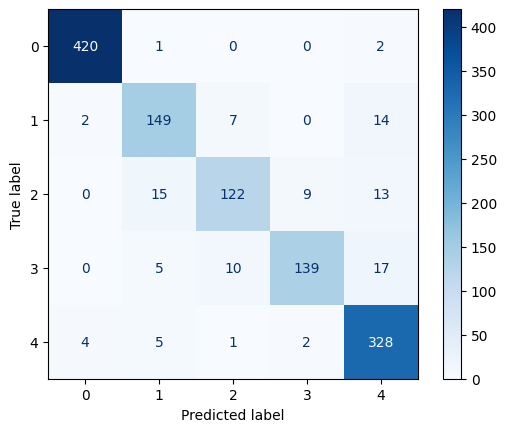

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.savefig('Confusion_Matrix.png')
plt.show()

In [49]:
import matplotlib.pyplot as plt

# Manually entered from your logs
train_losses = [
    1.1590, 0.8838, 0.7384, 0.6587, 0.5970, 0.5563, 0.5027, 0.4690, 0.4309, 0.3985,
    0.3624, 0.3364, 0.3072, 0.2862, 0.2683, 0.2551, 0.2343, 0.2356, 0.2040, 0.1902,
    0.1841, 0.1912, 0.1640, 0.1705, 0.1571, 0.1467, 0.1410, 0.1316, 0.1362, 0.1294
]

val_losses   = [
    0.9375, 0.7980, 0.6579, 0.6597, 0.5625, 0.5723, 0.4905, 0.4823, 0.3905, 0.4593,
    0.3717, 0.3572, 0.3928, 0.3576, 0.3249, 0.3119, 0.3149, 0.2569, 0.3138, 0.2420,
    0.3251, 0.2185, 0.2553, 0.2040, 0.2453, 0.2223, 0.1967, 0.1659, 0.2095, 0.2383
]

train_acc = [
    0.4951, 0.6222, 0.6900, 0.7260, 0.7438, 0.7703, 0.7948, 0.8051, 0.8268, 0.8401,
    0.8529, 0.8667, 0.8774, 0.8897, 0.8956, 0.9047, 0.9108, 0.9093, 0.9243, 0.9239,
    0.9300, 0.9241, 0.9377, 0.9338, 0.9371, 0.9431, 0.9454, 0.9498, 0.9476, 0.9482
]
val_acc   = [
    0.6032, 0.6522, 0.7154, 0.7083, 0.7526, 0.7660, 0.8055, 0.8063, 0.8458, 0.8079,
    0.8506, 0.8727, 0.8601, 0.8530, 0.8822, 0.8838, 0.8846, 0.9043, 0.8870, 0.9020,
    0.8933, 0.9186, 0.9059, 0.9273, 0.9154, 0.9186, 0.9257, 0.9415, 0.9233, 0.9241
]

epochs = list(range(1, 31))

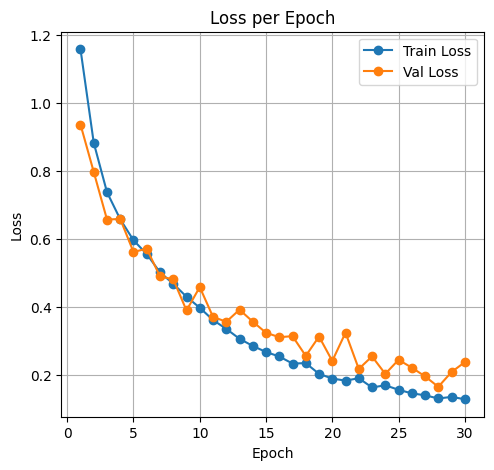

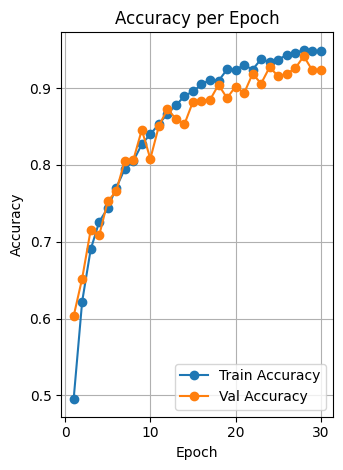

In [50]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.savefig('loss.png')
plt.show()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Val Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('accuracy.png')
plt.show()

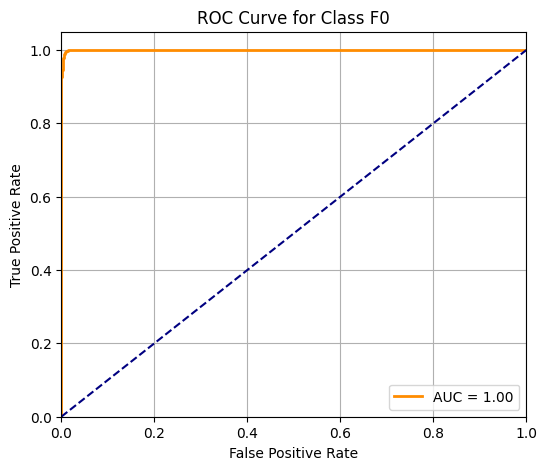

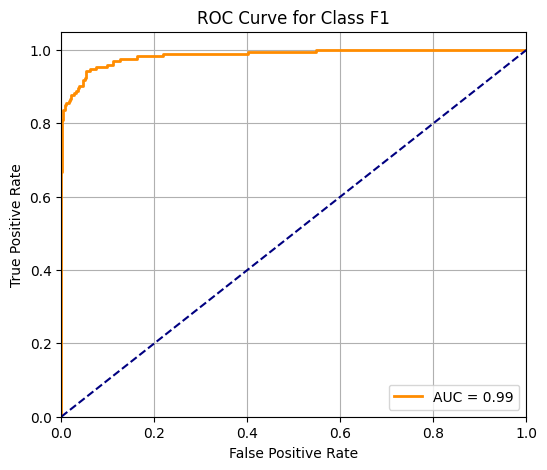

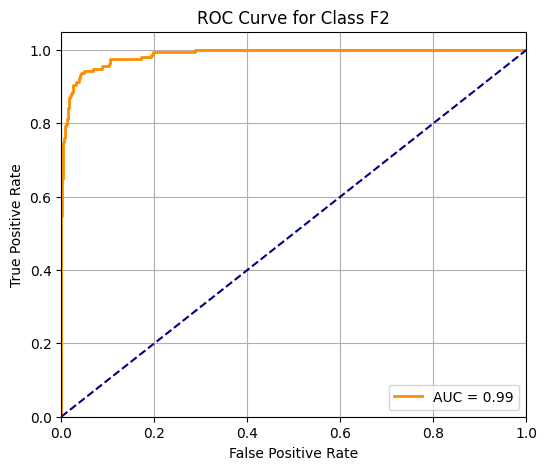

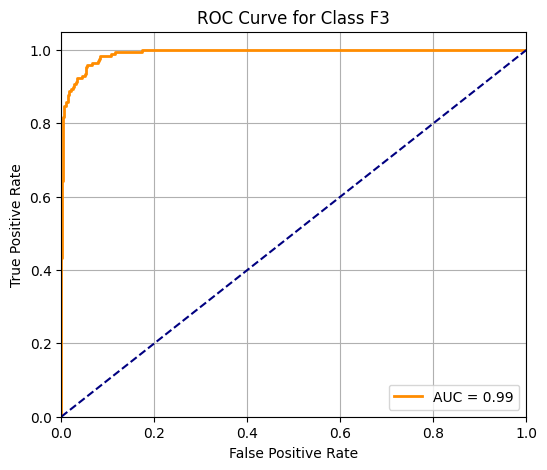

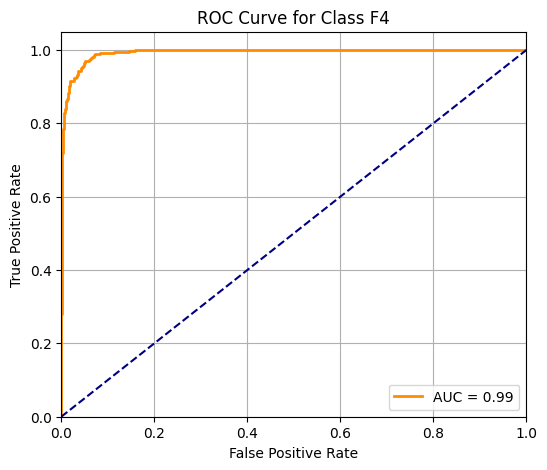

In [53]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Number of classes (fibrosis stages)
n_classes = 5
class_names = ['F0', 'F1', 'F2', 'F3', 'F4']

# Collect true labels and predicted probabilities
y_true = []
y_probs = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_probs = np.array(y_probs)

# One-hot encode the true labels
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Plot separate ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {class_names[i]}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(f'roc_curve_{class_names[i]}.png')
    plt.show()

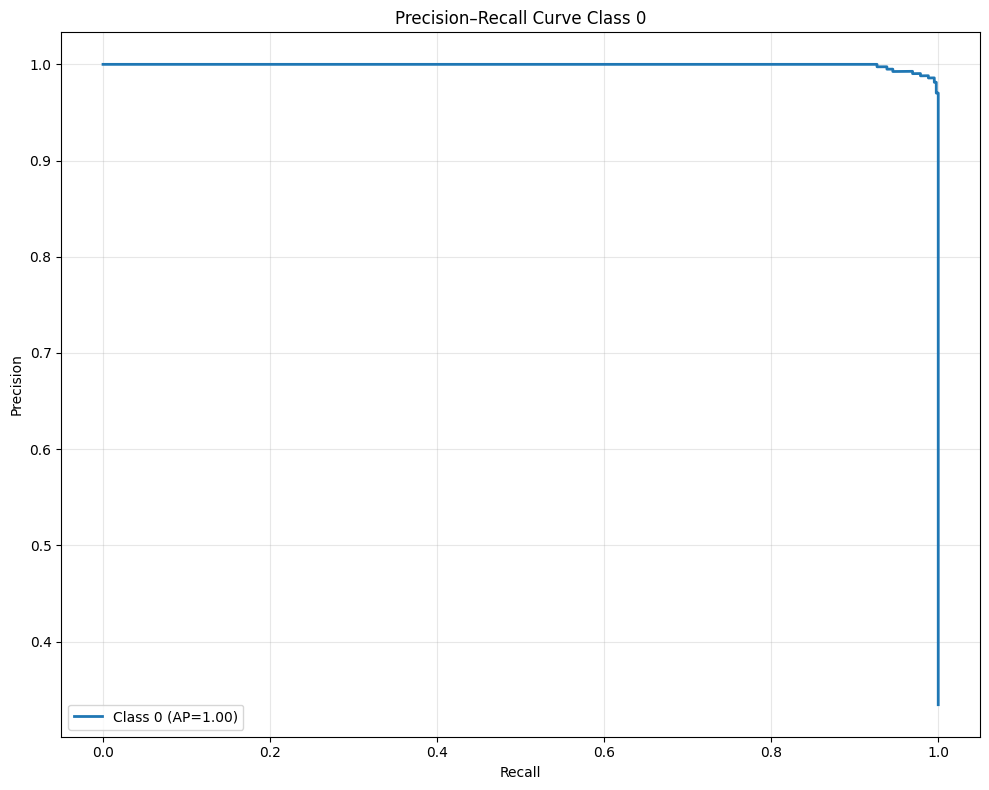

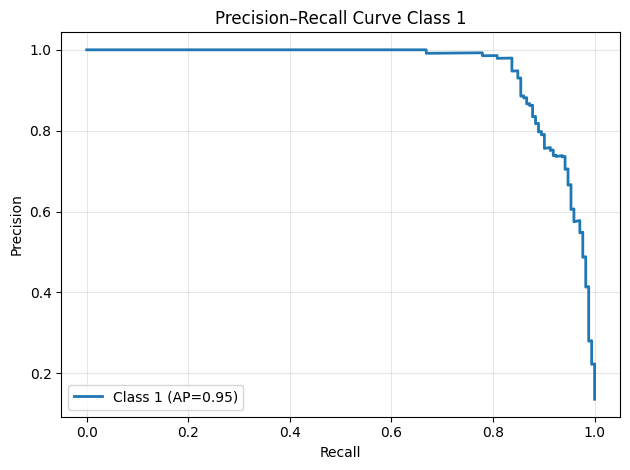

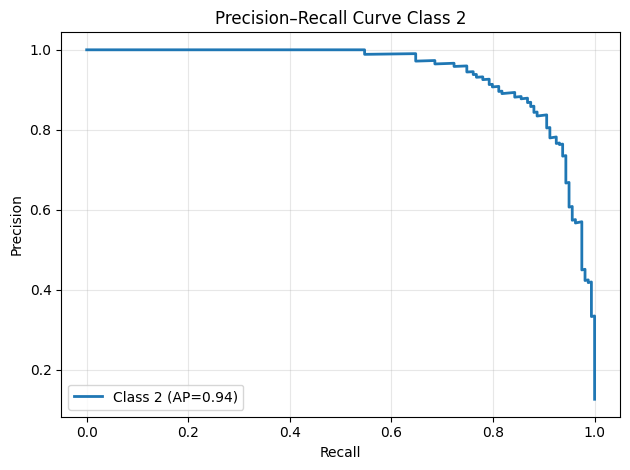

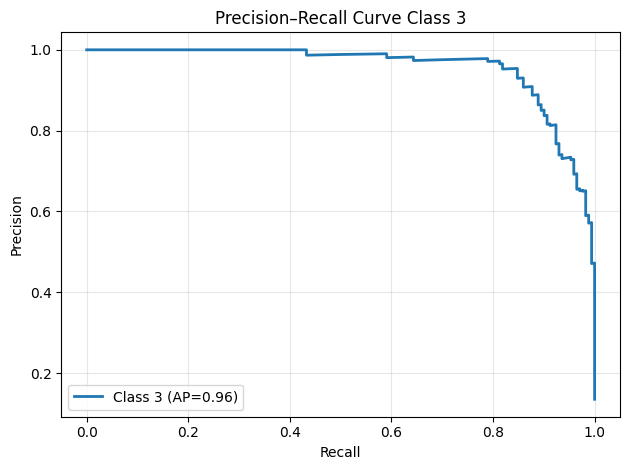

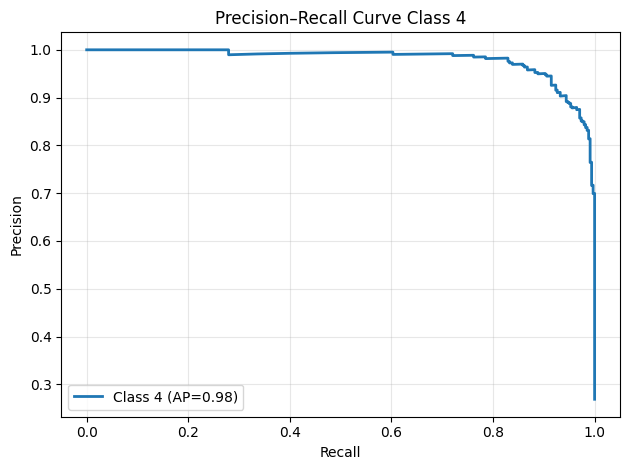

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# y_true: array of shape (n_samples,)
# y_score: array of shape (n_samples, n_classes)
# classes: list or range of class labels

# Example:
# y_true = np.array([0, 1, 2, 2, 0, 1])
# y_score = model.predict_proba(X_test)

# Use y_probs which was collected in the previous cell
# n_classes = y_score.shape[1] # This line caused the error
n_classes = y_probs.shape[1] # Use y_probs instead of y_score
y_true_bin = label_binarize(y_true, classes=range(n_classes))  # One-hot encoding

# Plot PR Curve
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    # Use y_probs instead of y_score
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
    ap_score = average_precision_score(y_true_bin[:, i], y_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f"Class {i} (AP={ap_score:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curve Class {i}")
    plt.legend(loc="lower left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'pr_curve{i}.png')
    plt.show()

In [60]:
from sklearn.metrics import classification_report
import numpy as np # Import numpy

# Assuming y_true and y_probs are available from previous cells

# Convert predicted probabilities to predicted class labels
y_pred = np.argmax(y_probs, axis=1) # Take the index of the max probability

# Now y_true (true labels) and y_pred (predicted labels) are in the same format (multiclass)
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

          F0       0.98      1.00      0.99       423
          F1       0.88      0.86      0.87       172
          F2       0.88      0.84      0.86       159
          F3       0.94      0.84      0.89       171
          F4       0.90      0.96      0.93       340

    accuracy                           0.93      1265
   macro avg       0.92      0.90      0.91      1265
weighted avg       0.93      0.93      0.93      1265



In [62]:
from sklearn.metrics import matthews_corrcoef
y_pred = np.argmax(y_probs, axis=1)
mcc = matthews_corrcoef(y_true, y_pred)
print("Matthews Correlation Coefficient:", mcc)

Matthews Correlation Coefficient: 0.9036360560847706


In [65]:
print(model.backbone.blocks[-1])

Sequential(
  (0): InvertedResidual(
    (conv_pw): Conv2d(272, 1632, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      1632, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (conv_dw): Conv2d(1632, 1632, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1632, bias=False)
    (bn2): BatchNormAct2d(
      1632, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (aa): Identity()
    (se): SqueezeExcite(
      (conv_reduce): Conv2d(1632, 68, kernel_size=(1, 1), stride=(1, 1))
      (act1): SiLU(inplace=True)
      (conv_expand): Conv2d(68, 1632, kernel_size=(1, 1), stride=(1, 1))
      (gate): Sigmoid()
    )
    (conv_pwl): Conv2d(1632, 448, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNormAct2d(
      448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      

In [66]:
target_layer = model.backbone.blocks[-1][1].conv_pwl

# You can print the target_layer to confirm you've selected the correct one
print("Identified target layer for Grad-CAM:")
print(target_layer)

Identified target layer for Grad-CAM:
Conv2d(2688, 448, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [68]:
from torchvision import transforms
from PIL import Image

# Load your test image
image_path = '/content/a1000.jpg'
img = Image.open(image_path).convert('RGB')

# Apply the same transforms as your training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # or your exact training values
])
input_tensor = transform(img).unsqueeze(0).to(device)

In [70]:
pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 848.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.6 MB/s

In [71]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

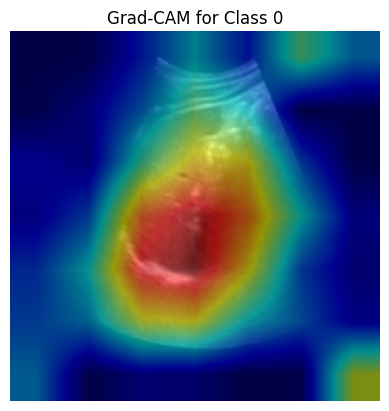

In [73]:
cam = GradCAM(model=model, target_layers=[target_layer])

# Use the correct class index from prediction
model.eval()
output = model(input_tensor)
pred_class = output.argmax().item()

# Grad-CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])
grayscale_cam = grayscale_cam[0, :]

# Convert image to format expected by show_cam_on_image
rgb_img = np.array(img.resize((224, 224))).astype(np.float32) / 255
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Plot
plt.imshow(cam_image)
plt.title(f"Grad-CAM for Class {pred_class}")
plt.axis('off')
plt.show()